In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from dataset import Dataset
from folder import Folder
from measurement import Measurement
from constants import channels, fs

import pickle

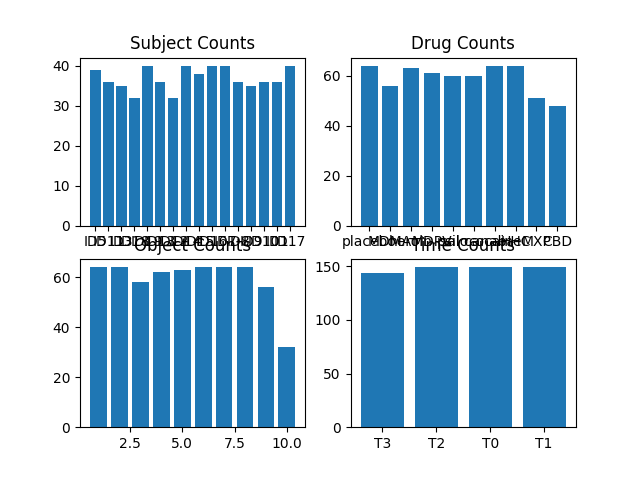

In [2]:
dataset = Dataset('saved_data.pickle', is_loaded=True)
dataset.sumarize_basic_stats()

In [ ]:
del dataset

In [4]:
from scipy.signal import spectrogram, iirnotch, butter, filtfilt
def get_max_freq_histogram(sig: np.ndarray) -> np.ndarray:
    b, a = iirnotch(50, Q=30, fs=fs)
    sig_f = filtfilt(b, a, sig)
    b, a = butter(N=4, Wn=[0.5, 45], btype='bandpass', fs=fs)
    sig_f = filtfilt(b, a, sig_f)

    f, t, Sxx = spectrogram(sig_f, fs, nperseg=512, noverlap=256)
    max_f = np.argmax(20 * np.log10(Sxx), axis=0)
    max_f = np.convolve(f[max_f], np.ones(10) / 10, mode='same')
    edge_bins = np.concatenate((np.linspace(0, 8, 20), np.array([40])))
    
    # DEBUG
    plt.figure()
    plt.imshow(Sxx)
    plt.plot(max_f, c='red')
    plt.show()
    # DEBUG

    return np.histogram(max_f, bins=edge_bins, density=True)

def get_diff_from_baseline(sig_b: np.ndarray, sig: np.ndarray) -> np.ndarray:
    b = get_max_freq_histogram(sig_b)[0]
    s = get_max_freq_histogram(sig)[0]
    return s - b

def get_feature_vector_t(measurement_baseline: Measurement, measurement: Measurement) -> np.ndarray:
    vector = []
    for ch in channels:
        diff_ch = get_diff_from_baseline(measurement_baseline[ch], measurement[ch])
        vector.append(diff_ch)
    return np.array(vector).flatten()

def get_all_points(dataset: Dataset) -> tuple[np.ndarray, list]:
    labels = list()
    points = []
    for i in range(len(dataset)):
        m = dataset[i]
        if m.time != 'T0': continue
        other_times = dataset.select(drug=m.drug, id=m.id)
        vec = list()
        for j in range(1, len(other_times)):
            vec.append(get_feature_vector_t(m, other_times[j]))
        vec = np.array(vec).flatten()
        if vec.shape[0] != 1080: continue
        points.append(vec)
        labels.append(m.drug)
    return points, labels

In [6]:
sig = dataset.folder.measurements[0]['O1'].measurement_data
plt.plot()
get_max_freq_histogram()

IndexError: tuple index out of range

In [5]:
points, labels = get_all_points(dataset)

In [ ]:
np.save('data_descriptors.py', points)
np.save('labels.py', np.array(labels))

5 9 8 6 0 1 4 2 3 7 5 9 8 0 1 4 2 3 7 5 9 8 6 0 2 3 7 5 9 8 6 0 4 2 3 7 5 9 8 6 0 1 4 2 3 7 5 8 6 1 4 2 3 7 5 9 8 6 0 1 4 2 3 7 5 9 8 6 0 1 4 2 3 5 9 8 6 0 1 4 3 7 5 9 8 6 0 1 4 2 3 5 9 8 6 0 1 4 2 3 5 9 8 6 0 4 2 3 7 5 9 8 6 1 4 2 3 7 5 9 8 6 0 1 4 2 3 7 5 9 8 0 1 4 2 3 7 5 9 8 6 4 2 3


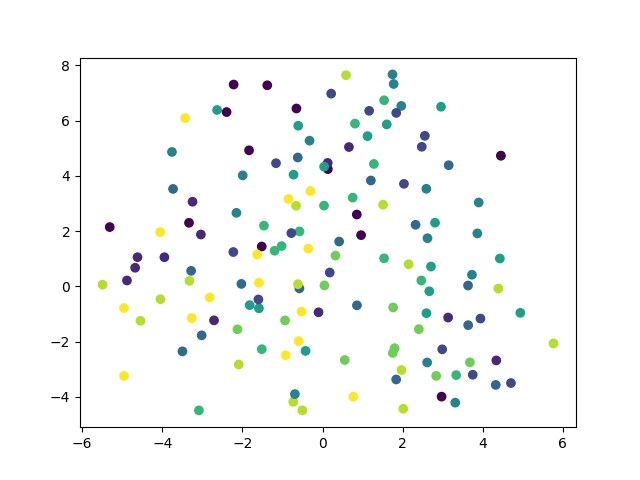

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_iter=50000)
fitted = tsne.fit_transform(np.array(points))
colors = [dataset.drugs.index(d) for d in labels]
print(*colors, sep=' ')

plt.figure('TSNE')
plt.clf()
plt.scatter(fitted[:, 0], fitted[:, 1], c=colors)
plt.show()

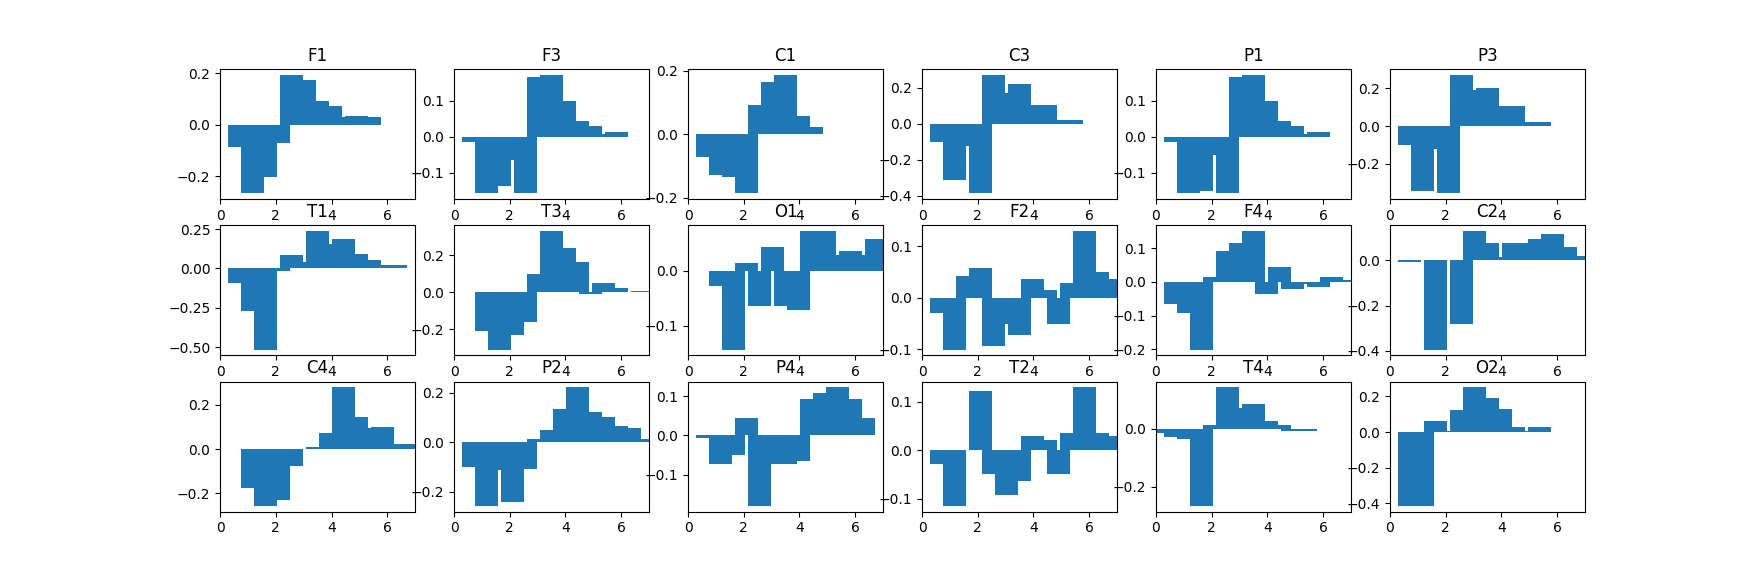

In [49]:
histograms = dict()
id = 0
drug = 'heroin'
for ch in channels:
    out = get_max_freq_histogram(dataset.select(drug=drug, time='T0')[id][ch])
    baseline = out[0]
    edge_bins = out[1]
    pos, _ = get_max_freq_histogram(dataset.select(drug=drug, time='T3')[id][ch])
    histograms[ch] = (edge_bins, pos - baseline)

plt.figure(f'{drug}')
plt.clf()

for i, ch in enumerate(channels):
    plt.subplot(3, 6, i+1)
    plt.title(ch)
    edges = histograms[ch][0]
    edges = (edges[1:] + edges[:-1]) / 2
    plt.bar(edges, histograms[ch][1], alpha=1)
    plt.xlim([0, 7])

plt.show()

In [ ]:
from standard_methods import get_most_common_freq

signal = dataset.select(drug='saline', time='T0')[1]['F1']
print(signal.shape)
cf, f = get_most_common_freq(signal)
print(cf.shape)
plt.plot(f, cf)
plt.xlim([0, 30])
plt.show()


In [ ]:

from scipy.signal import welch
for d in dataset.drugs:
    x = dataset.select(drug=d, time='T2')
    print(len(x))
    #print(*x, sep='\n')




In [ ]:
del dataset